# Lab: Regressions

In this lab, inspired by @igual_regression_2017, we will introduce simple linear regression in Python to try to answer the question: _Has there been a decrease in the amount of ice in the last years?_ To do so, we are going to use `Scikit Learn`, a machine learning library, and the [Sea Ice Index Daily and Monthly Image Viewer](https://nsidc.org/data/seaice_index) dataset from the National Snow and Ice Data Center.



## Key concepts' refresher

Let's refresh some theoretical concepts to understand what we are going to do.

### Simple and Multiple Linear Regression

In the **linear model** the response $\textbf{y}$ depends linearly from the covariates $\textbf{x}_i$.

In the **simple** linear regression, with a single variable, we described the relationship between the predictor and the response with a straight line. The general linear model:
$$ \textbf{y}  =  a_0+ a_1 \textbf{x}_1 $$

The parameter $a_0$ is called the *constant* term or the *intercept*.

In the case of **multiple** linear regression we extend this idea by fitting a m-dimensional hyperplane to our m predictors.

$$ \textbf{y}  =  a_1 \textbf{x}_1  + \dots + a_m \textbf{x}_{m} $$

The $a_i$ are termed the *parameters* of the model or the coefficients.

### Ordinary Least Squares

Ordinary Least Squares (OLS) is the simplest and most common **estimator** in which the coefficients $a$'s 
of the simple linear regression: $\textbf{y} = a_0+a_1 \textbf{x}$, 
are chosen to minimize the **square of the distance between the predicted values and the actual values**. 

$$ ||a_0 + a_1 \textbf{x} -  \textbf{y} ||^2_2 = \sum_{j=1}^n (a_0+a_1 x_{j} -  y_j )^2,$$ 

This expression is often called **sum of squared errors of prediction (SSE)**.

## Case study: Climate Change and Sea Ice Extent

Remember, we are trying to answer the following research question: _Has there been a decrease in the amount of ice in the last years?_

### Data assessment

First, let's load the `SeaIce.txt` dataset that is already in the `data` folder[^seaice]. It is a text file, but unlike `csv` files, where columns are separated by commas (`,`), it is a `Tab` separated file, where each `Tab` delimites the following columns:

- `Year`:	4-digit year
- `mo`:	1- or 2-digit month
- `data_type`:	Input data set (Goddard/NRTSI-G)
- `region`:	Hemisphere that this data covers (N: Northern; S: Southern)
- `extent`:	Sea ice extent in millions of square km
- `area`:	Sea ice area in millions of square km

Once we upload the data, we can create a `DataFrame` using Pandas using the well known `read_csv()` function, but in this case, because columns are not separated by commas as expected, but Tabs, we will need to use the `delim_whitespace=True` argument. 

[^seaice]: The original dataset was downloaded from <https://nsidc.org/data/g02135/versions/3>, which provides useful metadata information, as well as API services.


In [1]:
import pandas as pd
ice = pd.read_csv('data/raw/SeaIce.txt', delim_whitespace=True)

ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       424 non-null    int64  
 1   mo         424 non-null    int64  
 2   data_type  424 non-null    object 
 3   region     424 non-null    object 
 4   extent     424 non-null    float64
 5   area       424 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 20.0+ KB


In [2]:
ice.head() 

,year,mo,data_type,region,extent,area
0,1979,1,Goddard,N,15.54,12.33
1,1980,1,Goddard,N,14.96,11.85
2,1981,1,Goddard,N,15.03,11.82
3,1982,1,Goddard,N,15.26,12.11
4,1983,1,Goddard,N,15.10,11.92


And we can get some summary statistics from the numerical attributes:

In [3]:
ice.describe()

,year,mo,extent,area
count,424.000000,424.000000,424.000000,424.000000
mean,1996.000000,6.500000,-35.443066,-37.921108
std,10.214716,3.474323,686.736905,686.566381
min,1978.000000,1.000000,-9999.000000,-9999.000000
25%,1987.000000,3.000000,9.272500,6.347500
50%,1996.000000,6.500000,12.385000,9.895000
75%,2005.000000,10.000000,14.540000,12.222500
max,2014.000000,12.000000,16.450000,13.840000


::: callout-warning

Did we receive a negative mean for `extent` and `area`? What this could possibly mean? Probably, inspecting those attributes visually could give us a clue.

:::

### Data visualisation to explore data

We will use Seaborn's `lmplot()` function to explore linear relationship of different forms, e.g. relationship between the `month` of the `year` (variable) and `extent` (responses):

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Text(0, 0.5, 'Extent')

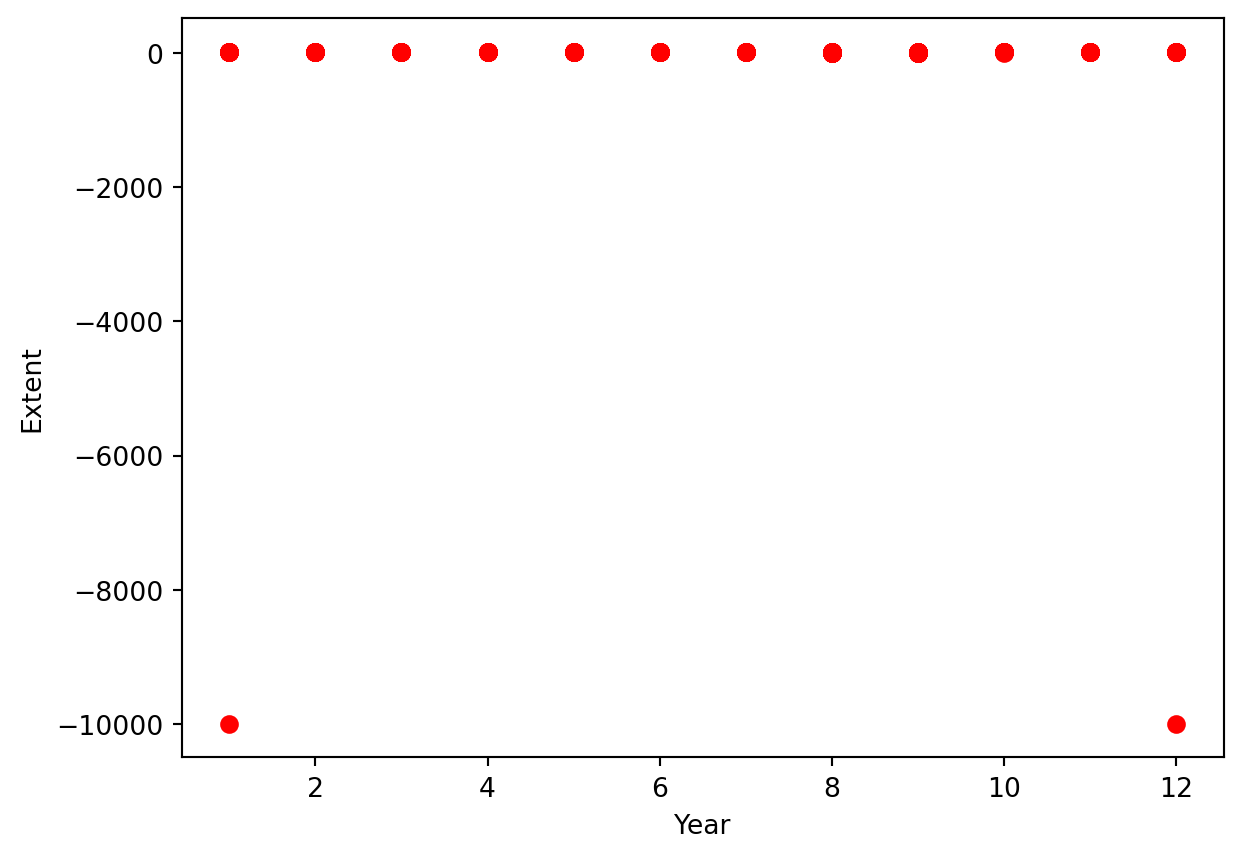

In [5]:
# Visualize the data
plt.scatter(ice.mo, ice.extent, color = 'red')
plt.xlabel('Year')
plt.ylabel('Extent')

::: callout-warning

We detect some outlier or missing data. This might have to do with those negative mean values that we detected previously.

:::

We can use numpy's function [`np.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) to find the unique elements of an array.

In [6]:
print ('Different values in data_type field:', np.unique(ice.data_type.values))   # there is a -9999 value!

Different values in data_type field: ['-9999' 'Goddard' 'NRTSI-G']


Let's see what type of data we have, other than the ones printed above 

In [7]:
print (ice[(ice.data_type != 'Goddard')
          & (ice.data_type != 'NRTSI-G')])

     year  mo data_type region  extent    area
9    1988   1     -9999      N -9999.0 -9999.0
397  1987  12     -9999      N -9999.0 -9999.0


### Data cleaning

We checked all the values and notice `-9999` values in data_type field which should contain `Goddard` or `NRTSI-G` (some type of input dataset).

In this case, we will clean them by creating a _copy_ of the original dataframe that does not include these instances.

::: callout-important

### Dataframe copies vs instances

Unless we do not explicitly create a copy of a dataframe, when subsetting a dataframes we are actually creating instances. Whereas copies are totally independent objects from the original one, instances are reduced "views" from the original, meaning that if we change a value on the instance, we are also changing the value on the original data frame, which may not be what we wanted to do. 

An explanation of how (and why) do we need to create copies can be found here: <https://www.statology.org/pandas-copy-dataframe/>

:::

In [8]:
# We can easily clean the data now:
ice2 = ice[ice.data_type != '-9999'].copy()

print ('shape:', ice2.shape)

shape: (422, 6)


Text(0, 0.5, 'Extent')

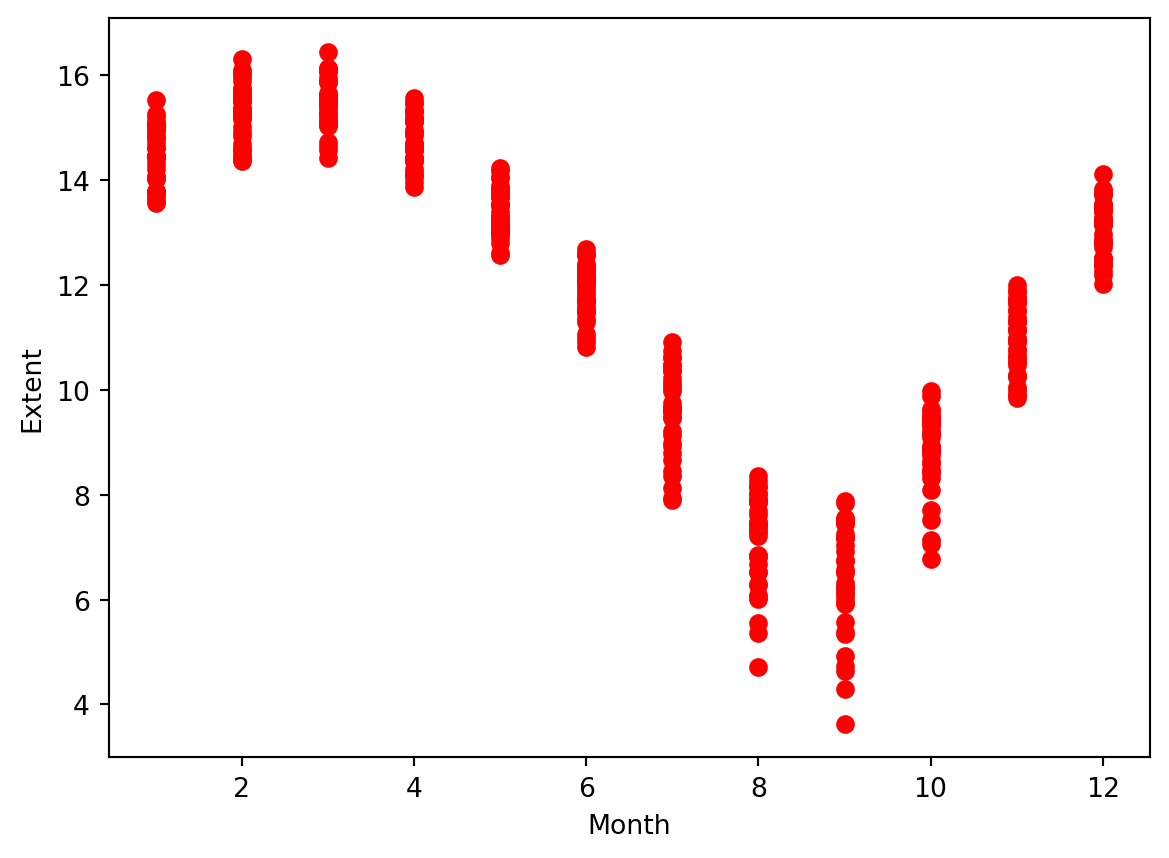

In [9]:
# And repeat the plot, without the outliers
plt.scatter(ice2.mo, ice2.extent, color = 'red')
plt.xlabel('Month')
plt.ylabel('Extent')

/Users/u2071219/anaconda3/envs/IM939/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/u2071219/anaconda3/envs/IM939/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/u2071219/anaconda3/envs/IM939/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/u2071219/anaconda3/envs/IM939/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

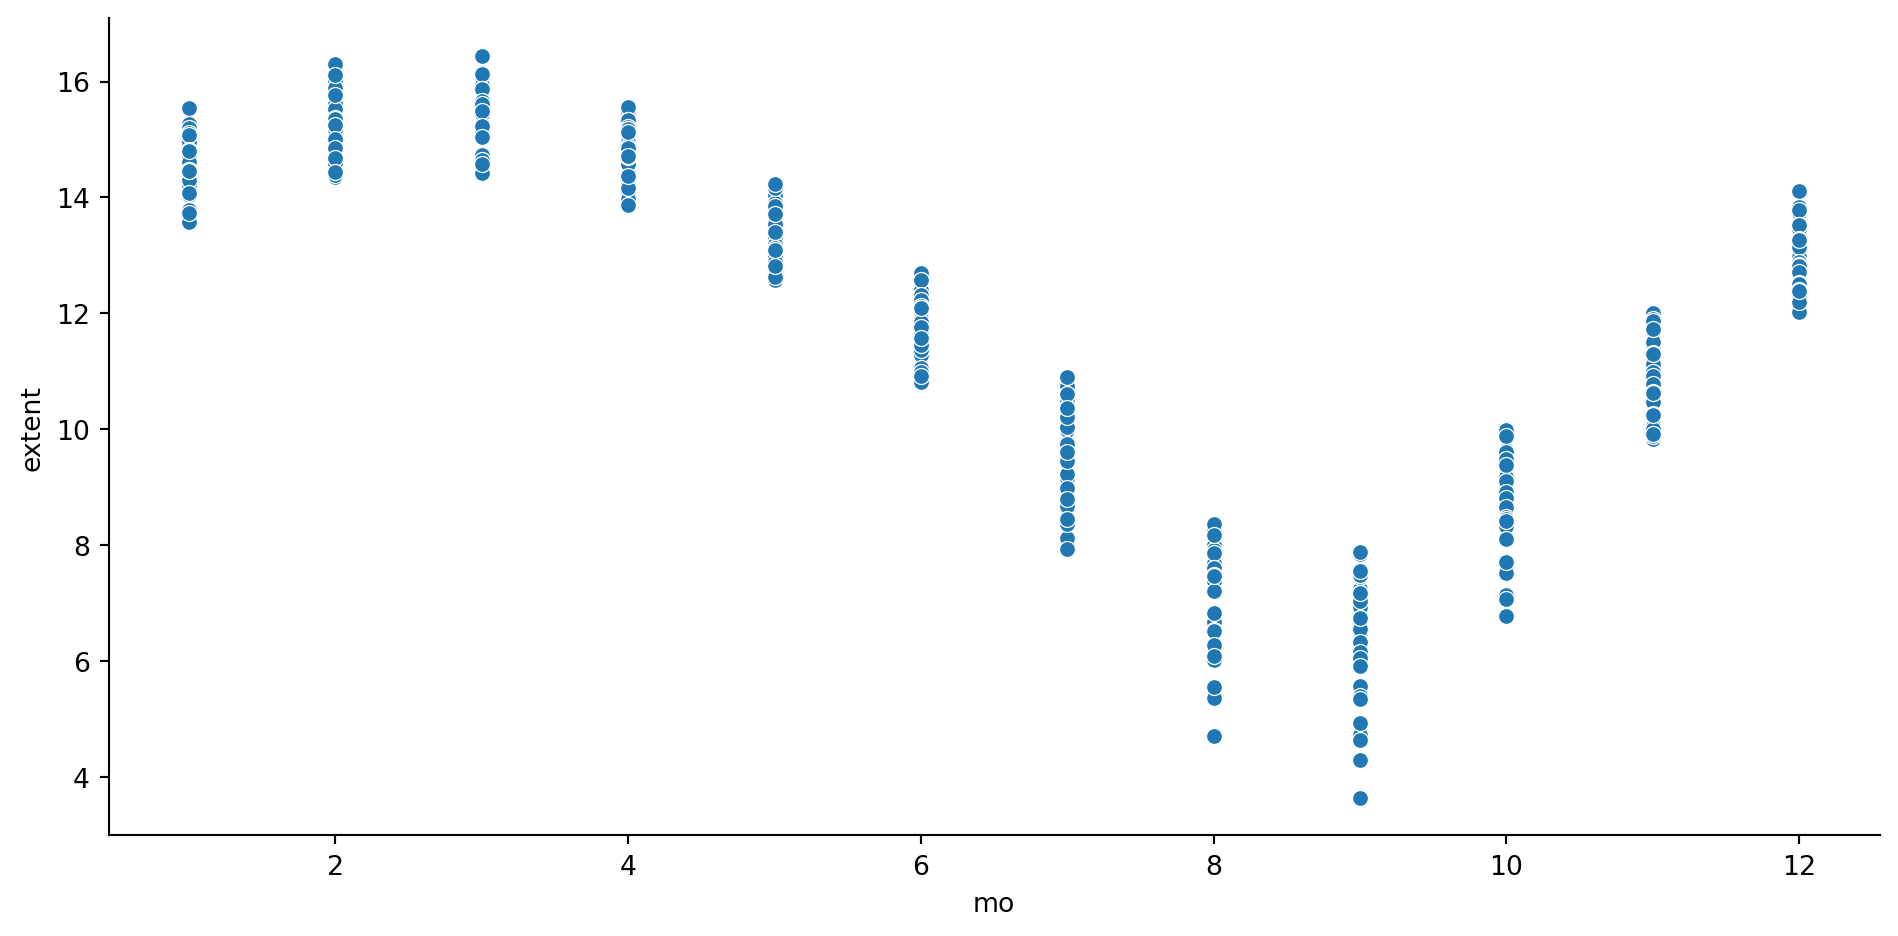

In [10]:
#| column: page-right

sns.relplot(ice2, x = "mo", y = "extent", aspect = 2)

## Regression model fit

Now that we have a clean dataset, we can use Seaborn's [`lmplot()`](https://seaborn.pydata.org/generated/seaborn.lmplot.html) function comparing month vs extent. 

The `lmplot()` function from the Seaborn module is intended for exploring linear relationships of different forms in multidimensional datesets. Input data must be in a Pandas DataFrame. To plot them, we provide the predictor (`mo`) and response (`extent`) variable names along with the dataset (`ice2`).

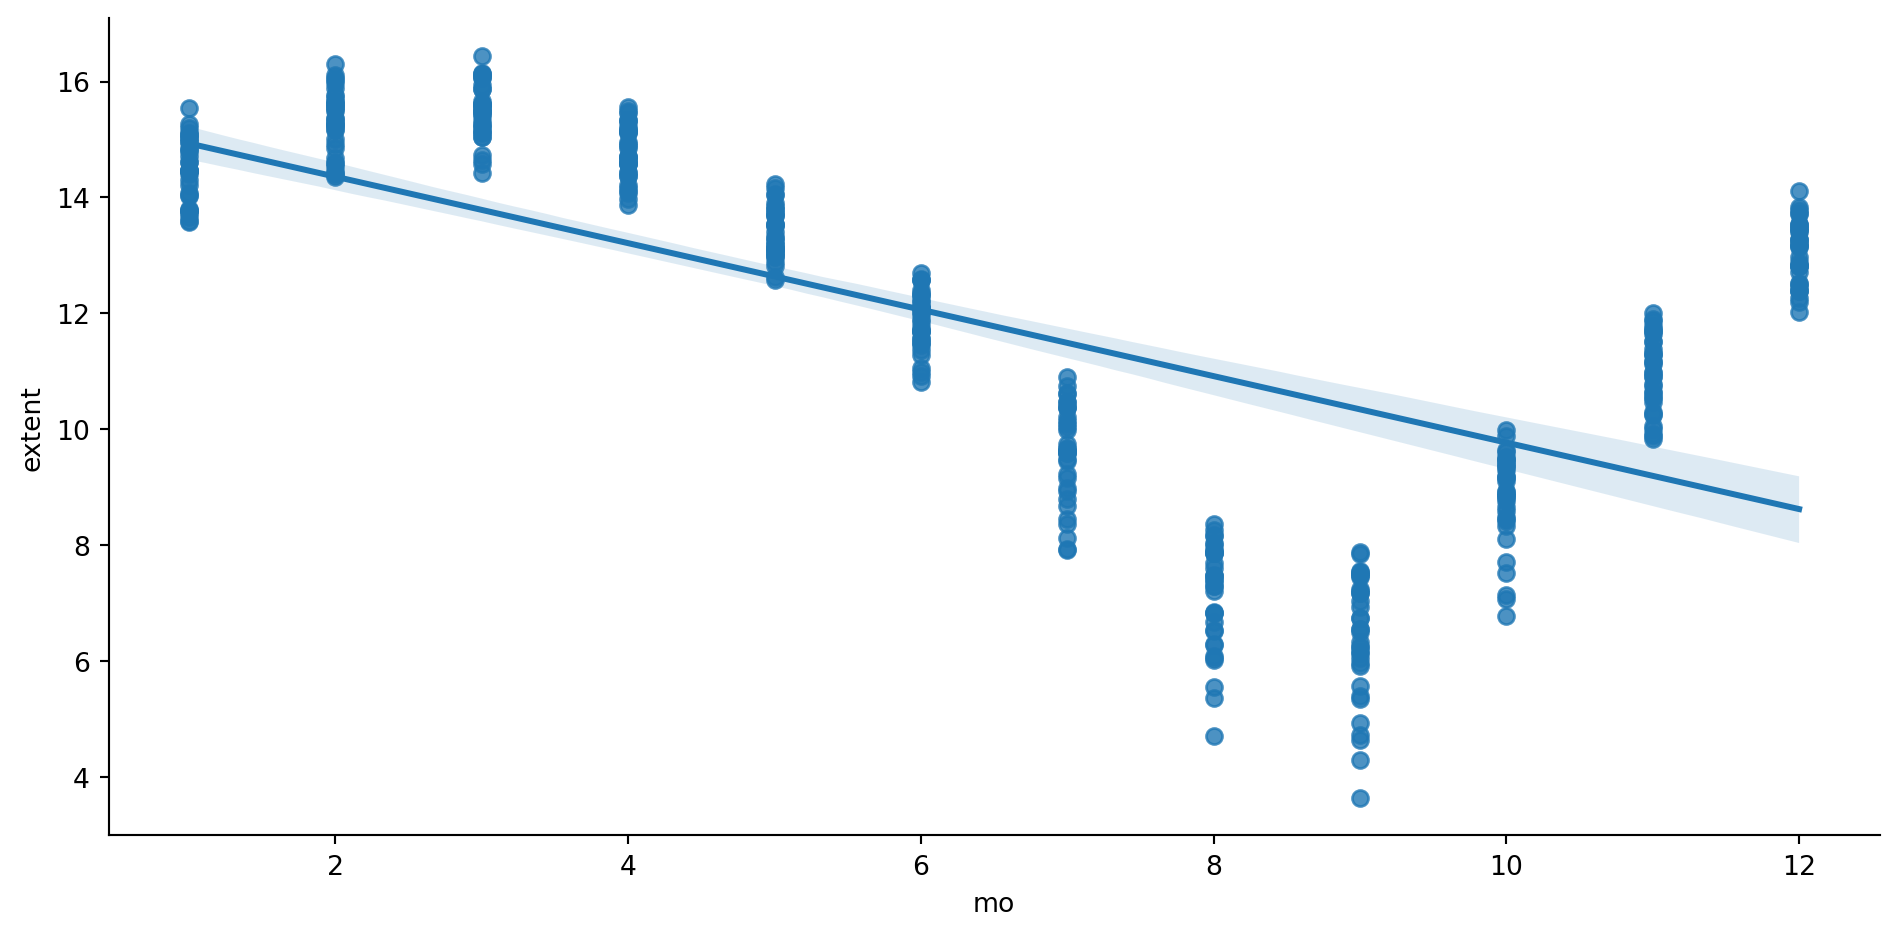

In [11]:
#| column: page-right

sns.lmplot(ice2, x = "mo", y = "extent", aspect=2);

# Uncomment below to save the resulting plot.
#plt.savefig("figs/CleanedByMonth.png", dpi = 300, bbox_inches = 'tight')

Above you can see ice extent data by month.
You can see a monthly fluctuation of the sea ice extent, as would be expected for the different seasons of the year. In order to run regression, and avoid this fluctuation we can normalize data. This will let us see the evolution of the extent over the years.

### Normalization


In [12]:
# Compute the mean for each month.
month_means = ice2.groupby('mo').extent.mean()

# Compute the variance for each month.
month_variances = ice2.groupby('mo').extent.var()

# Show the values:
print('Means:', month_means)
print('\n') # Add a new line between the two prints, so they are easily distinguishible.
print ('Variances:',month_variances)

Means: mo
1     14.479429
2     15.298889
3     15.491714
4     14.766000
5     13.396000
6     11.860000
7      9.601143
8      7.122286
9      6.404857
10     8.809143
11    10.964722
12    13.059429
Name: extent, dtype: float64


Variances: mo
1     0.304906
2     0.295804
3     0.237209
4     0.215378
5     0.189901
6     0.247918
7     0.679175
8     0.824577
9     1.143902
10    0.630361
11    0.412511
12    0.284870
Name: extent, dtype: float64


To capture variation per month, we can compute mean for the i-th interval of time (using 1979-2014) and subtract it from the set of extent values for that month . This can be converted to a relative pecentage difference by dividing it by the total avareage (1979-2014) and multiplying by 100.

/var/folders/7v/zl9mv52s3ls94kntlt_l9ryh0000gq/T/ipykernel_73230/2141240604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ice2.extent[ice2.mo == i+1] = 100*(ice2.extent[ice2.mo == i+1] - month_means[i+1])/month_means.mean()
/var/folders/7v/zl9mv52s3ls94kntlt_l9ryh0000gq/T/ipykernel_73230/2141240604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ice2.extent[ice2.mo == i+1] = 100*(ice2.extent[ice2.mo == i+1] - month_means[i+1])/month_means.mean()
/var/folders/7v/zl9mv52s3ls94kntlt_l9ryh0000gq/T/ipykernel_73230/2141240604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

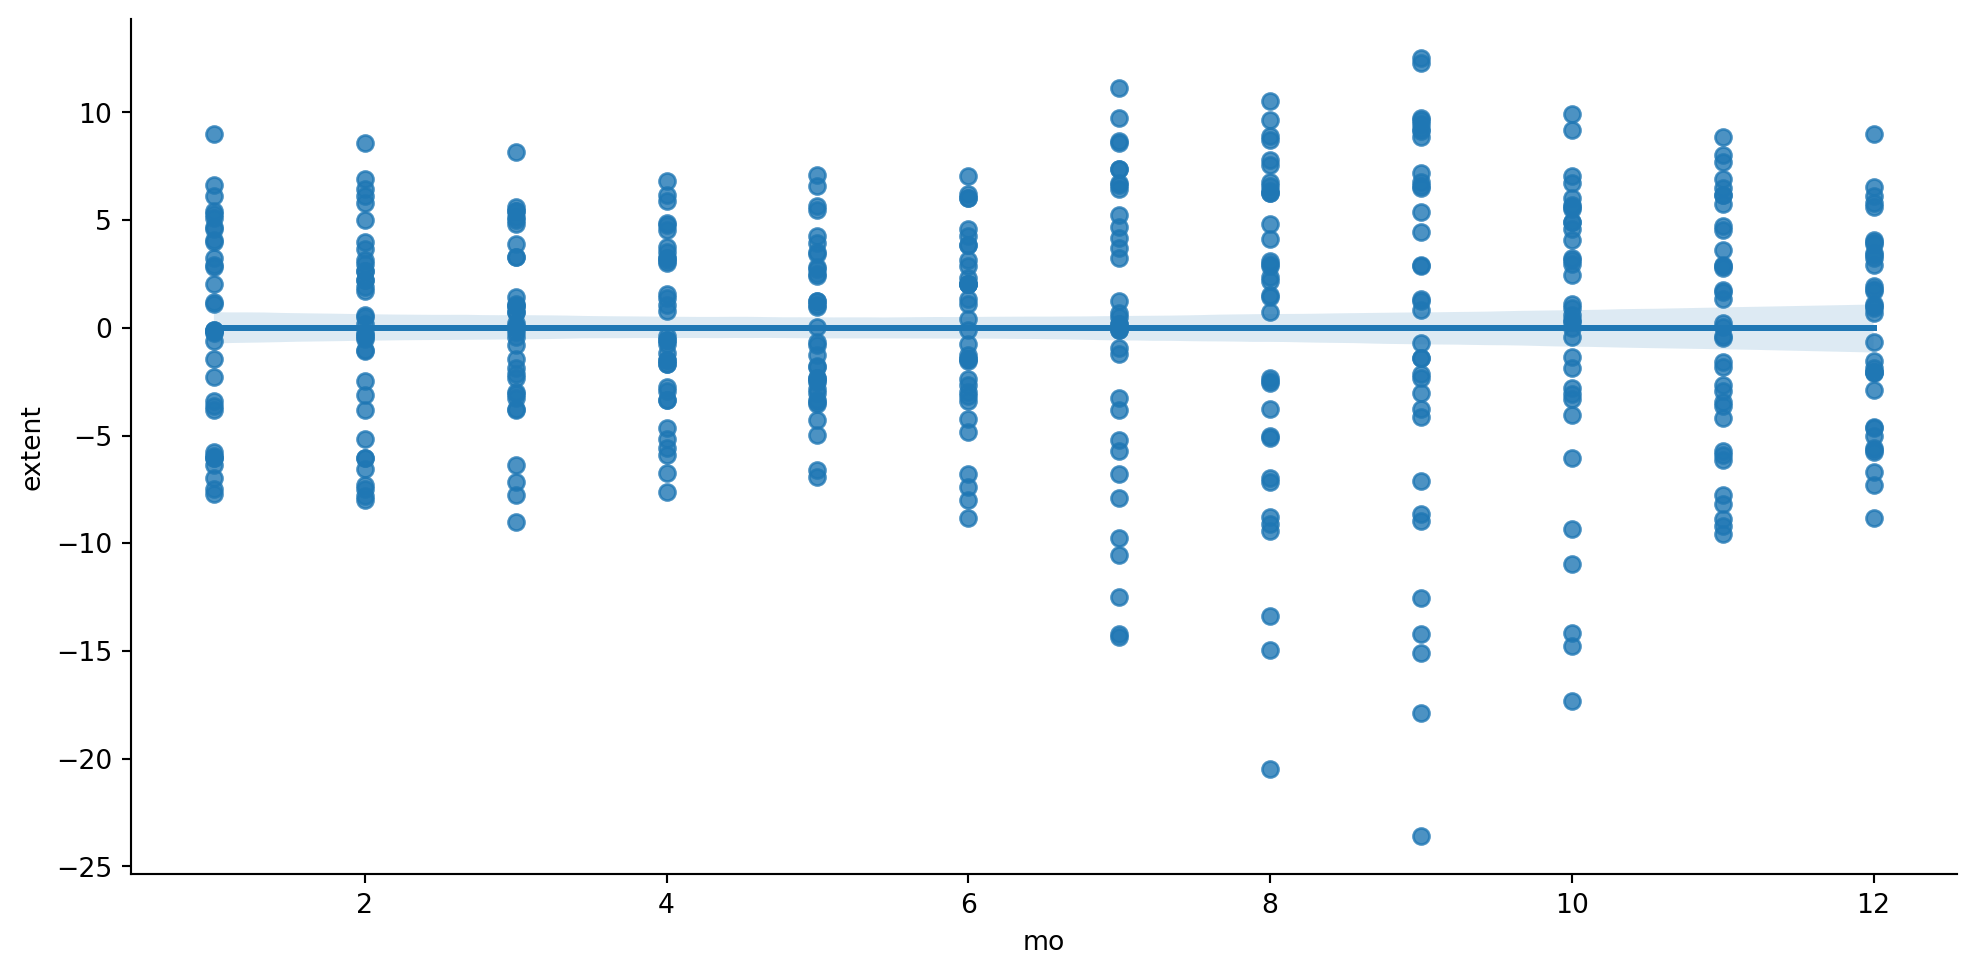

In [13]:
# Data normalization
for i in range(12):
    ice2.extent[ice2.mo == i+1] = 100*(ice2.extent[ice2.mo == i+1] - month_means[i+1])/month_means.mean()
    
sns.lmplot(ice2 , x = "mo", y = "extent", height = 5.2, aspect = 2);
#plt.savefig("figs/IceExtentNormalizedByMonth.png", dpi = 300, bbox_inches = 'tight')

In [14]:
print ('mean:', ice2.extent.mean())
print ('var:', ice2.extent.var())

mean: -7.745252569896827e-16
var: 31.983239774968798


Let us consider the entire year

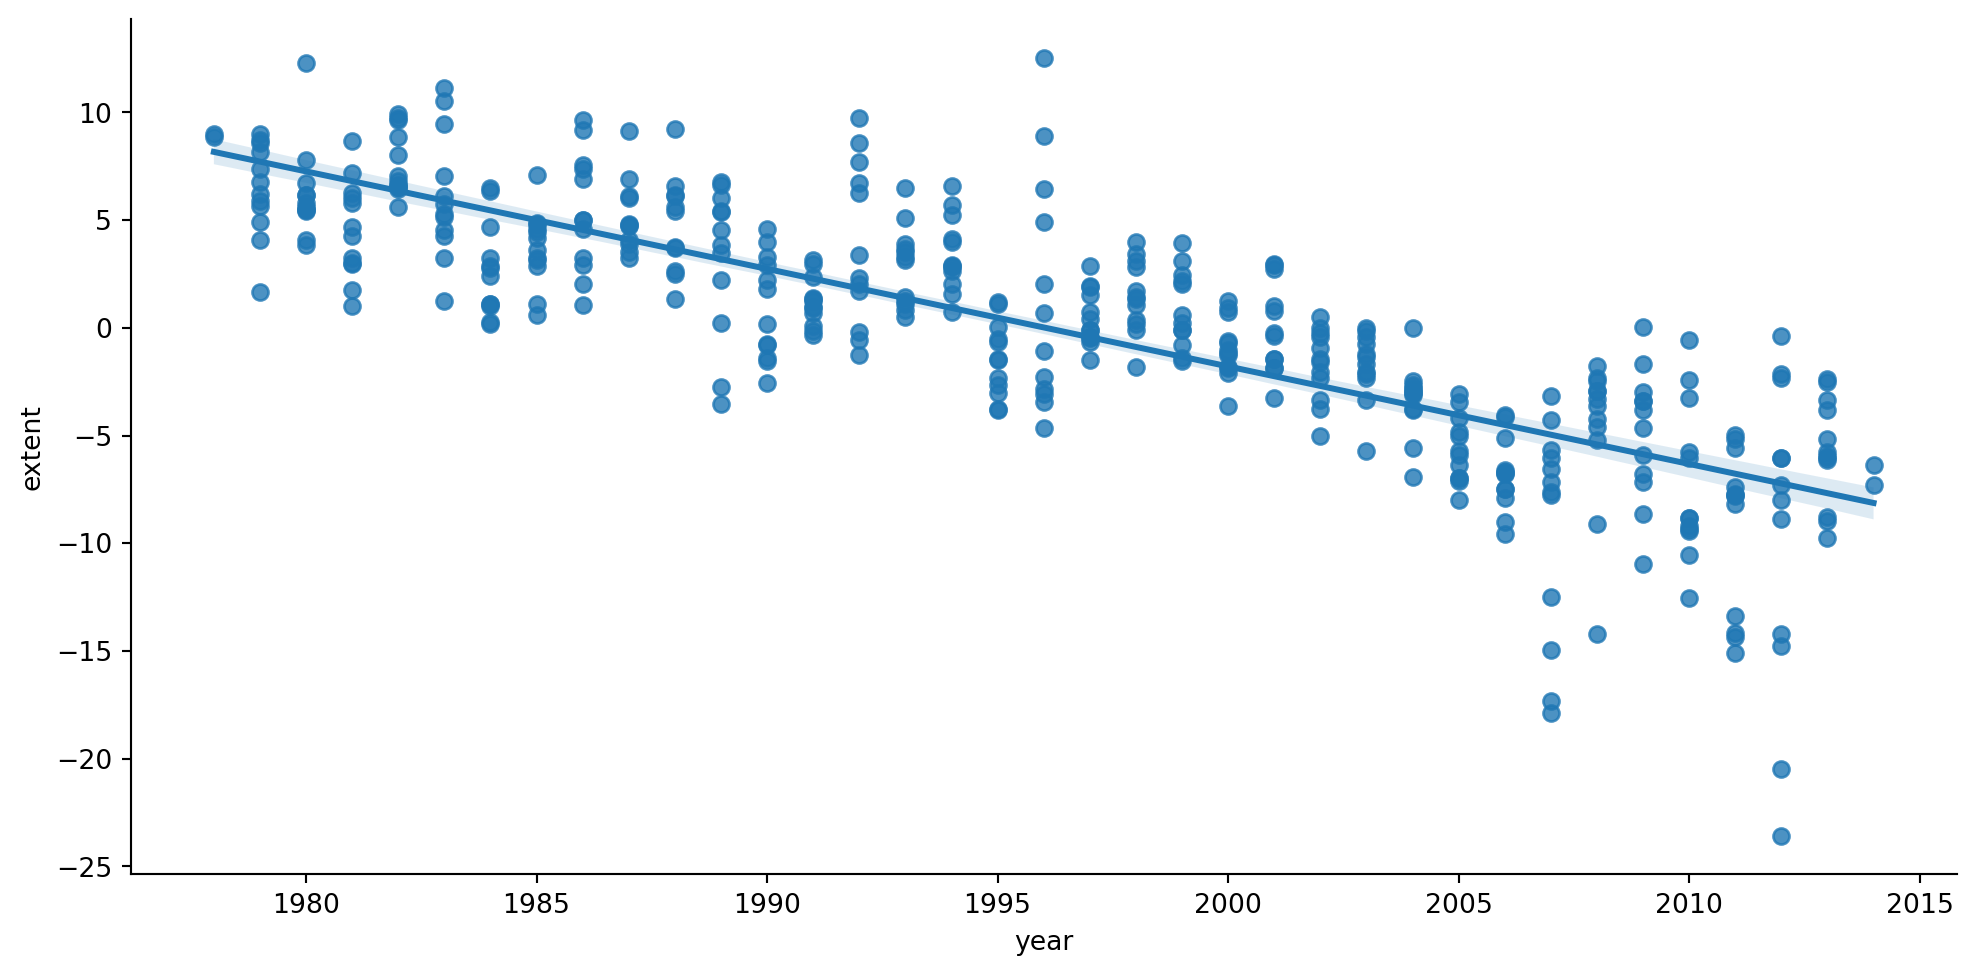

In [15]:
sns.lmplot(ice2, x = "year", y = "extent", height = 5.2, aspect = 2);
#plt.savefig("figs/IceExtentAllMonthsByYearlmplot.png", dpi = 300, bbox_inches = 'tight')

### Pearson's correlation

Let's calculate Pearson's correlation coefficient and the p-value for testing non-correlation.

In [16]:
import scipy.stats
scipy.stats.pearsonr(ice2.year.values, ice2.extent.values)

PearsonRResult(statistic=-0.8183500709897178, pvalue=4.4492318168687107e-103)

### Simple OLS

We can also compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.

For that we use using **Scikit-learn**, library that provides a variety of both supervised and unsupervised machine learning techniques.
Scikit-learn provides an object-oriented interface centered around the concept of an Estimator. 
The <code>Estimator.fit</code> method sets the state of the estimator based on the training data. Usually, the data is comprised of a two-dimensional numpy array $X$ of shape <code>(n_samples, n_predictors)</code> that holds the so-called feature matrix and a one-dimensional numpy array $\textbf{y}$ that holds the responses. Some estimators allow the user to control the fitting behavior. 
For example, the <code>sklearn.linear_model.LinearRegression</code> estimator allows the user to specify whether or not to fit an intercept term. This is done by setting the corresponding constructor arguments of the estimator object.
During the fitting process, the state of the estimator is stored in instance attributes that have a trailing underscore (`_`). For example, the coefficients of a LinearRegression estimator are stored in the attribute `coef_`.

Estimators that can generate predictions provide a `Estimator.predict` method. 
In the case of regression, `Estimator.predict` will return the predicted regression values, $\hat{\textbf{y}}$. 

In [17]:
from sklearn.linear_model import LinearRegression

est = LinearRegression(fit_intercept = True)

x = ice2[['year']]
y = ice2[['extent']]

est.fit(x, y)

print("Coefficients:", est.coef_)
print ("Intercept:", est.intercept_)

Coefficients: [[-0.45275459]]
Intercept: [903.71640207]


We can evaluate the model fitting by computing the mean squared error ($MSE$) and the coefficient of determination ($R^2$) of the model.
The coefficient $R^2$ is defined as $(1 - \textbf{u}/\textbf{v})$, where $\textbf{u}$ is the residual sum of squares $\sum (\textbf{y} - \hat{\textbf{y}})^2$ and $\textbf{v}$ is the regression sum of squares $\sum (\textbf{y} - \bar{\textbf{y}})^2$, where $\bar{\textbf{y}}$ is the mean.
The best possible score for $R^2$ is 1.0: lower values are worse.
These measures can provide a quantitative answer to the question we are facing: Is there a negative trend in the evolution of sea ice extent over recent years?

MSE: 10.539131639803488
R^2: 0.5067870382100226
var: extent    31.98324
dtype: float64


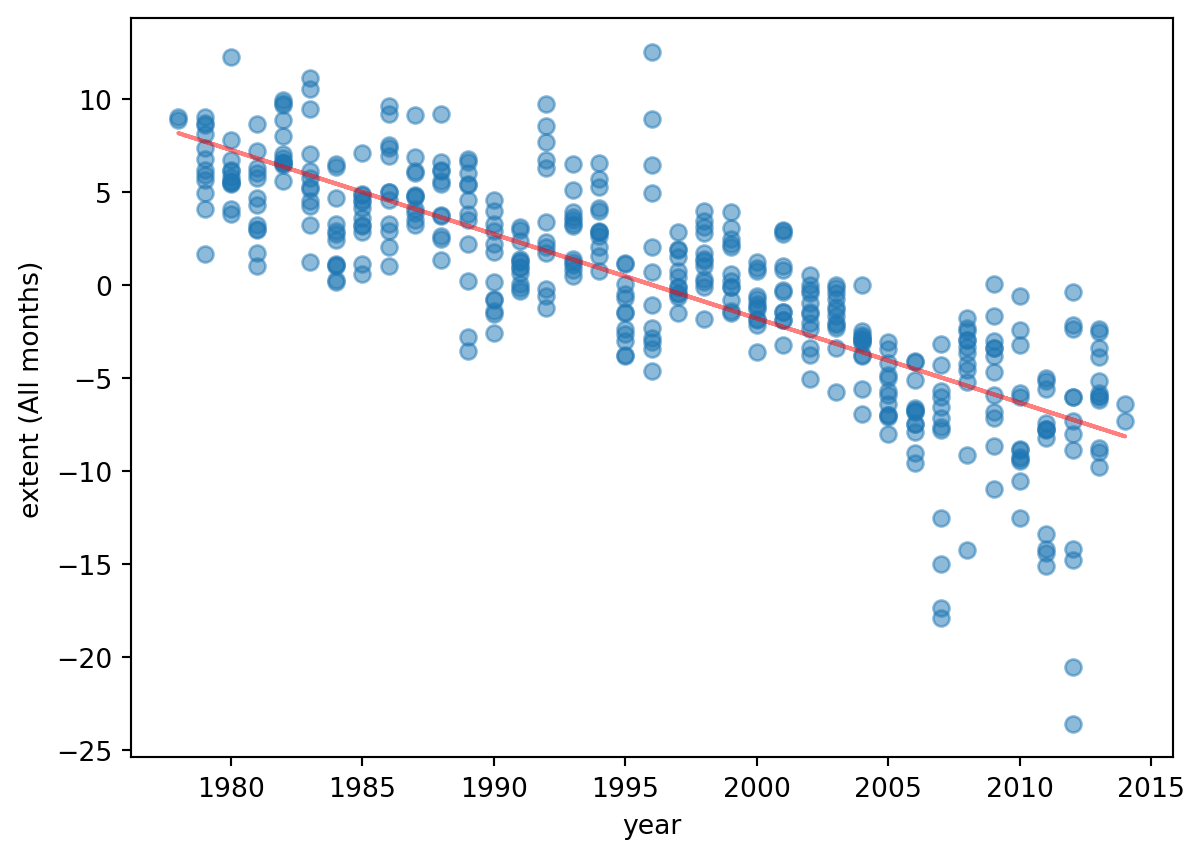

In [18]:
from sklearn import metrics

# Analysis for all months together.
x = ice2[['year']]
y = ice2[['extent']]
model = LinearRegression()
model.fit(x, y)
y_hat = model.predict(x)
plt.plot(x, y,'o', alpha = 0.5)
plt.plot(x, y_hat, 'r', alpha = 0.5)
plt.xlabel('year')
plt.ylabel('extent (All months)')
print ("MSE:", metrics.mean_squared_error(y_hat, y))
print ("R^2:", metrics.r2_score(y_hat, y))
print ("var:", y.var())
#plt.savefig("figs/IceExtentLinearRegressionAllMonthsByYearPrediction.png", dpi = 300, bbox_inches = 'tight')

We can conclude that the data show a long-term negative trend in recent years.

MSE: 3.8395160752867565
R^2: 0.7810636041396216


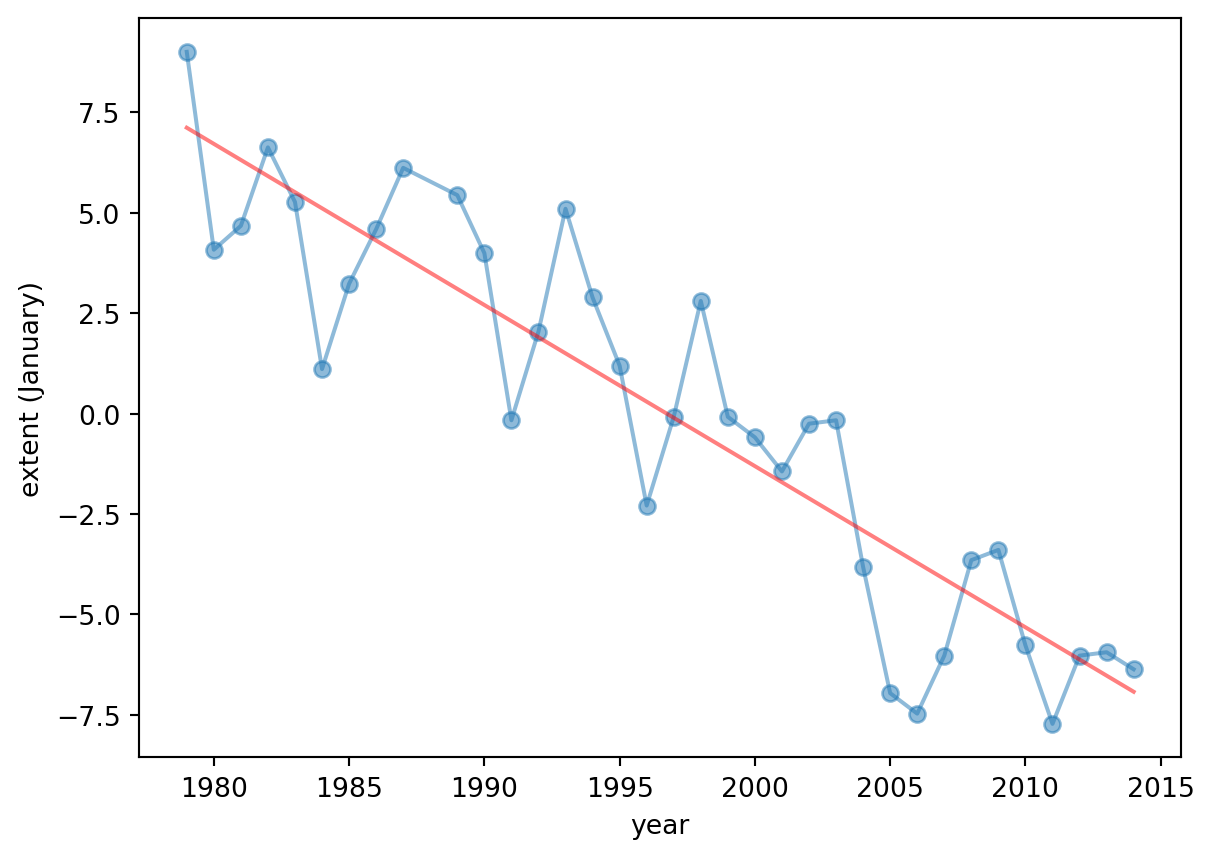

In [19]:
# Analysis for a particular month.
#For January
jan = ice2[ice2.mo == 1];

x = jan[['year']]
y = jan[['extent']]

model = LinearRegression()
model.fit(x, y)

y_hat = model.predict(x)

plt.figure()
plt.plot(x, y,'-o', alpha = 0.5)
plt.plot(x, y_hat, 'r', alpha = 0.5)
plt.xlabel('year')
plt.ylabel('extent (January)')

print ("MSE:", metrics.mean_squared_error(y_hat, y))
print ("R^2:", metrics.r2_score(y_hat, y))

We can also estimate the extent value for 2025. For that we use the function predict of the model.

In [20]:
X = np.array(2025) 
y_hat = model.predict(X.reshape(-1, 1))
j = 1 # January
# Original value (before normalization)
y_hat = (y_hat*month_means.mean()/100) + month_means[j]
print ("Prediction of extent for January 2025 (in millions of square km):", y_hat)

Prediction of extent for January 2025 (in millions of square km): [[13.14449923]]


/Users/u2071219/anaconda3/envs/IM939/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Prediction of extent for January 2025 (in millions of square km): 13.14449923

## More information

You can find more information about using `scikit` for Linear regression here: <https://www.tutorialspoint.com/scikit_learn/scikit_learn_linear_regression.htm>